In [1]:
# dependent modules in this project
import pickle
import csv

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import sklearn.model_selection
import tensorflow as tf

## Step 0: Load The Data

In [58]:
# Load pickled data

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [4]:
# map csv file

dict_id_signName = {}

#read signnames.csv
with open('signnames.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        dict_id_signName[(int(row['ClassId']))] = row['SignName']

print (dict_id_signName)

{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight o

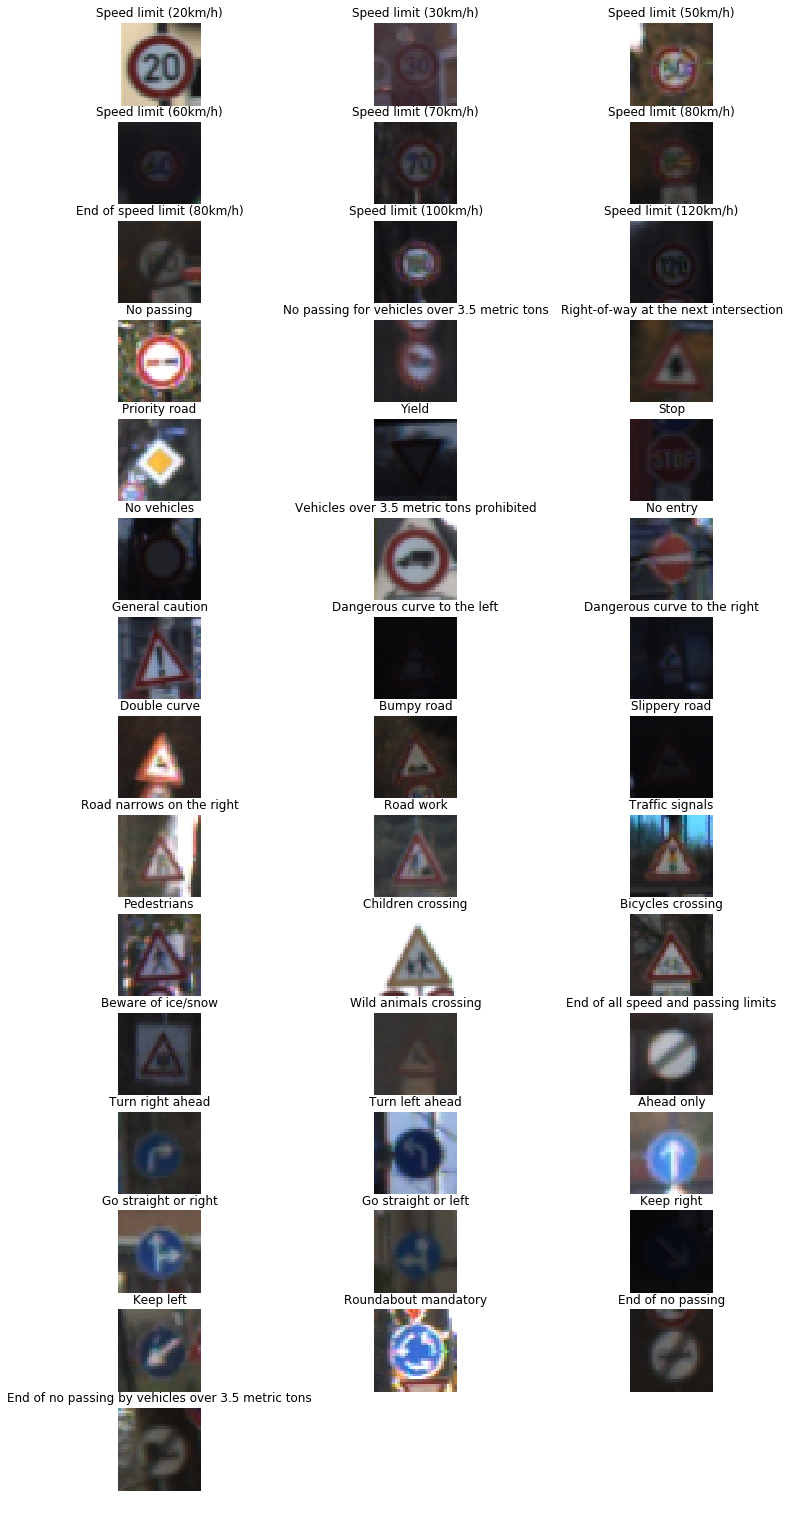

In [5]:
# I was using the idea of NikolasEnt on github in this block
n_imgsPerClass=[]
plt.figure(figsize=(13, 27))
for i in range(0, n_classes):
    plt.subplot(15, 3, i+1)
    x_selected = X_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :]) #draw the first image of each class
    plt.title(dict_id_signName[i])
    plt.axis('off')
    n_imgsPerClass.append(len(x_selected))
plt.show()


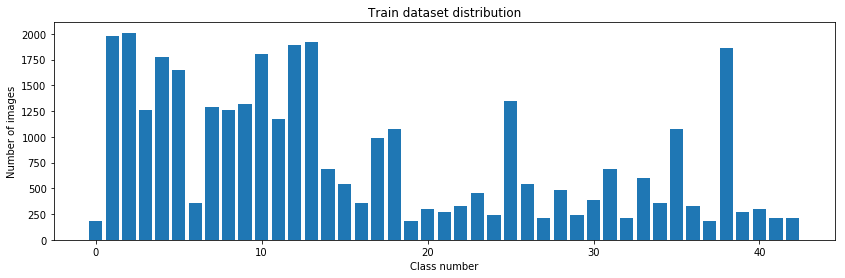

Stats : Min in a class 180, Max in a class 2010


In [38]:
# plot distribution based on images in each class
plt.figure(figsize=(14, 4))
plt.bar(range(0, n_classes), n_imgsPerClass)
plt.title("Train dataset distribution")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

print("Stats : Min in a class {}, Max in a class {}".format( min(n_imgsPerClass), max(n_imgsPerClass) ))

We can see from the plot that some classes contain less data. So affine transformations and filters can be applied on them so that we can generate a larger data set to train the model

In [60]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

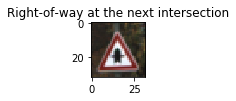

In [59]:
#randomly pick some dataset sample to check if they are properly matched
import matplotlib.image as mpimg

rand_num = 9410
img = X_train[rand_num]

plt.figure(figsize =(1,1))
plt.imshow(img)
plt.title(dict_id_signName[y_train[rand_num]])
plt.show()

In [52]:
X_train = np.concatenate((X_train,X_valid));
y_train = np.concatenate((y_train,y_valid));
print(X_train.shape,y_train.shape)

(39209, 32, 32, 3) (39209,)


As I am using KERAS in solving the problem, I don't need to explictly divide the data into training and validation.

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Before training the model, each pixel need to be normalized to avoid increase of loss function

### Model Architecture

In [62]:
# Initial Setup for Keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

### Train and Validate the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

A Convolution Layer with 32 filters and kernel size of 3 and stride of 3 is selected in 1st layer and the output is flattened and outputted to 128 neurons and final output layer which was fully connected has 43 logits 

In [63]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(43, activation='softmax'))

# preprocess data
X_train = np.array(X_train / 255.0 - 0.5 )

from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y_train)

model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_train, y_one_hot, nb_epoch=10, validation_split=0.2)

Train on 27839 samples, validate on 6960 samples
Epoch 1/10
27839/27839 [==============================] - 15s - loss: 0.8205 - acc: 0.7811 - val_loss: 0.3332 - val_acc: 0.9086
Epoch 2/10
27839/27839 [==============================] - 15s - loss: 0.1881 - acc: 0.9511 - val_loss: 0.1933 - val_acc: 0.9483
Epoch 3/10
27839/27839 [==============================] - 15s - loss: 0.1153 - acc: 0.9690 - val_loss: 0.1511 - val_acc: 0.9614
Epoch 4/10
27839/27839 [==============================] - 15s - loss: 0.0739 - acc: 0.9797 - val_loss: 0.1885 - val_acc: 0.9555
Epoch 5/10
27839/27839 [==============================] - 15s - loss: 0.0588 - acc: 0.9843 - val_loss: 0.2365 - val_acc: 0.9470
Epoch 6/10
27839/27839 [==============================] - 15s - loss: 0.0621 - acc: 0.9834 - val_loss: 0.2428 - val_acc: 0.9473
Epoch 7/10
27839/27839 [==============================] - 15s - loss: 0.0469 - acc: 0.9877 - val_loss: 0.1461 - val_acc: 0.9694
Epoch 8/10
27839/27839 [==============================]

### Testing of Model

In [64]:
X_test = np.array(X_test / 255.0 - 0.5 )
y_one_hot = label_binarizer.fit_transform(y_test)

metrics = model.evaluate(X_test, y_one_hot)
for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    print('{}: {}'.format(metric_name, metric_value))

12630/12630 [==============================] - 2s     
loss: 1.0460434320986696
acc: 0.8634204275911985


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Testing on images from Web

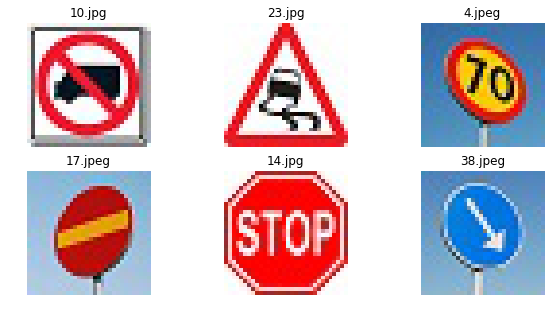

In [65]:
import os
list_testimages=os.listdir("newtest/")
X_pred = []
def show_imgs(list_imgs):
    plt.figure(figsize=(10, 5))
    for i in range(len(list_imgs)):
        plt.subplot(2, 3, i+1)
        test_image= mpimg.imread("newtest/"+list_imgs[i])
        plt.imshow(test_image)
        plt.title(list_imgs[i])
        plt.axis('off')
        X_pred.append(test_image)
    plt.show()
show_imgs(list_testimages)
X_pred = np.array(X_pred)

#images maped with their codes in German Data Set

In [66]:
#Normalize prediction data
X_pred_norm = np.array(X_pred / 255.0 - 0.5 )
pred_data = model.predict_classes(X_pred_norm)

6/6 [==============================] - 0s


#### Predictions from Built Model

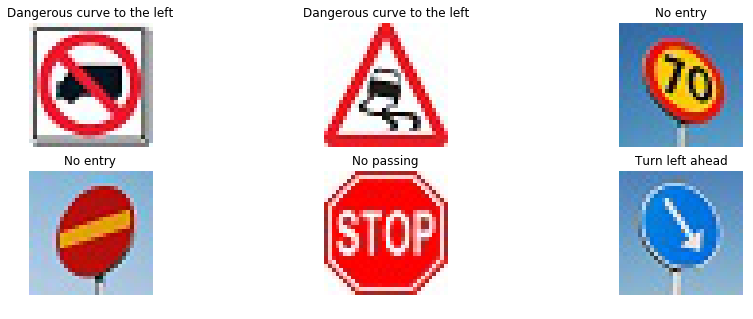

In [67]:
plt.figure(figsize=(15,5))
for index,pred in enumerate(pred_data):
    plt.subplot(2,3,index+1)
    plt.imshow(X_pred[index])
    plt.title(dict_id_signName[pred])
    plt.axis('off')
plt.show()

### Analyze Performance

One out of 6 images is classified only one image correctly. Even though Validation accuracy is good enough, the model couldn't perform well on Test Data

Some images were directly choosen which appear as drawing, I think the model found it difficult as the are not photographic and it might be confused in understanding a bit more detailed image than regular one

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")